# Comprehensive Analysis and Prediction of Housing Prices: A Machine Learning Approach with XGBoost in AWS SageMaker

# Table of Contents
1. [The Dataset](#the-dataset)
2. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
   1. [Understanding the Data](#1-understanding-the-data---overview)
   2. [Statistical Information of Numerical Columns](#2-statistical-information-of-numerical-columns)
   3. [Statistical Information of Non-Numerical Columns](#3statistical-information-of-non-numerical-columns)
   4. [Missing Values](#4missing-values)
   5. [Distribution Analysis](#5-distribution-analysis)
   6. [Correlation Analysis](#6correlation-analysis)
3. [Data Cleaning](#data-cleaning)
   1. [Dealing with Missing Value](#1-dealinf-with-missing-value)
   2. [Outlier Removal](#2-outlier-removal)
   3. [Dropping Unimportant Columns](#dropping-unimportant-columns)
4. [Feature Engineering](#feature-engineering)
   1. [Derived Feature Creation](#1-derived-feature-creation)
   2. [Ordinal Variables Mapping](#2-ordinal-variables-mapping)
   3. [One-Hot Encoding (Categorical Features)](#3-one-hot-encoding--categorical-features)
5. [Modeling](#modeling)
   1. [Setup](#setup)
   2. [Prediction Type](#prediction-type)
   3. [Feature Scaling with StandardScaler](#feature-scaling-with-standanrdscaler)
   4. [Splitting Data (Train-Test-Split)](#splitting-data-train-test-split)
   5. [Saving Train Data to S3](#saving-train-data-to-s3)
6. [XGBoost Model](#xgboost-model)
   1. [Container Image and Training Job](#xgboost-container-image-and-training-job)
   2. [Training](#training)
   3. [Hyperparameter Tuning](#hyperparameter-tuning)
7. [Inferencing](#inferencing)
   1. [Hosting the Model](#hosting-the-model)
   2. [Endpoint Config](#endpoint-config)
   3. [Creating Endpoint](#creating-endpoint)
   4. [Prediction](#prediction)
   5. [MAE Comparison](#mae-comparison)
   6. [Prediction Accuracy Test: MAE, RMSE and r²](#prediction-accuracy-test-mae-rmse-and-r2)
8. [Report](#report)


<a id="the-dataset"></a>
# THE DATASET

### I will analyze a residential property dataset originally compiled by De Cock in 2011, detailing property sales in Ames, Iowa, spanning from 2006 to 2010. The dataset contains `2930` records (rows) and `82` features (columns).

DATA SOURCE: https://www.kaggle.com/datasets/prevek18/ames-housing-dataset/



## Reading the Dataset


In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("AmesHousing.csv")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# Display basic information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [4]:
# Configuring float numbers format
pd.options.display.float_format = '{:20.2f}'.format
dataset.head(n=5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.00,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.00,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


<a id="exploratory-data-analysis-eda"></a>
# EXPLORATORY DATA ANALYSIS (EDA)

<a id="1-understanding-the-data---overview"></a>
## 1. Understanding the Data - Overview

 Numerical data: These include columns like 'Lot Frontage', 'Lot Area', 'Year Built', 'SalePrice', etc.
 
 Categorical data: These are columns like 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Neighborhood', etc.

For the exploratory data analysis (EDA), I'll focus on several aspects:

      Summary Statistics: Basic statistical details like count, mean, standard deviation, etc.
  
      Missing Values: Identification of columns with missing values and their extent.
  
      Distribution of Key Features: Analyzing the distribution of certain important features like 'SalePrice'.
  
      Correlation Analysis: Understanding how different numerical features are related to each other, 
      especially with respect to 'SalePrice'.

Let's start with the summary statistics and information about missing values.

<a id="2-statistical-information-of-numerical-columns"></a>
## 2. Statistical Information of Numerical Columns

In [5]:
dataset.describe(include=[np.number], percentiles=[.5]) \
    .transpose().drop("count", axis=1)

,mean,std,min,50%,max
Order,1465.50,845.96,1.00,1465.50,2930.00
PID,714464496.99,188730844.65,526301100.00,535453620.00,1007100110.00
MS SubClass,57.39,42.64,20.00,50.00,190.00
Lot Frontage,69.22,23.37,21.00,68.00,313.00
Lot Area,10147.92,7880.02,1300.00,9436.50,215245.00
Overall Qual,6.09,1.41,1.00,6.00,10.00
Overall Cond,5.56,1.11,1.00,5.00,9.00
Year Built,1971.36,30.25,1872.00,1973.00,2010.00
Year Remod/Add,1984.27,20.86,1950.00,1993.00,2010.00
Mas Vnr Area,101.90,179.11,0.00,0.00,1600.00


   =The SalePrice (target variable) has a mean of approximately \\$180,796 and a standard deviation of \\$79,886.
    
   =The range of Year Built for the houses spans from 1872 to 2010.
    
   -Features like Lot Area, Overall Qual, and Overall Cond show a wide range of values, indicating diverse housing characteristics.

<a id="3-statistical-information-of-non-numerical-columns"></a>
## 3.Statistical information of NON-NUMERICAL COLUMNS

In [7]:
dataset.describe(include=[np.object]).transpose() \
    .drop("count", axis=1)

/tmp/ipykernel_10134/811848876.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dataset.describe(include=[np.object]).transpose() \


,unique,top,freq
MS Zoning,7,RL,2273
Street,2,Pave,2918
Alley,2,Grvl,120
Lot Shape,4,Reg,1859
Land Contour,4,Lvl,2633
Utilities,3,AllPub,2927
Lot Config,5,Inside,2140
Land Slope,3,Gtl,2789
Neighborhood,28,NAmes,443
Condition 1,9,Norm,2522


<a id="4-missing-values"></a>
##  4.Missing Values

In [8]:
# Information about missing values
missing_values = dataset.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Cond        159
Garage Qual        159
Garage Finish      159
Garage Yr Blt      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Half Bath       2
Bsmt Full Bath       2
BsmtFin SF 1         1
Garage Cars          1
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
Electrical           1
dtype: int64

### Several columns have missing values, some with a significant number:

   -Pool QC, Misc Feature, Alley, and Fence have the highest number of missing values, indicating that many houses do not have these features.
    
   -Fireplace Qu and Lot Frontage also have a substantial number of missing values.
    
   -Other features related to the garage, basement, and masonry veneer also show missing values.

<a id="5-distribution-analysis"></a>
## 5. Distribution Analysis: 

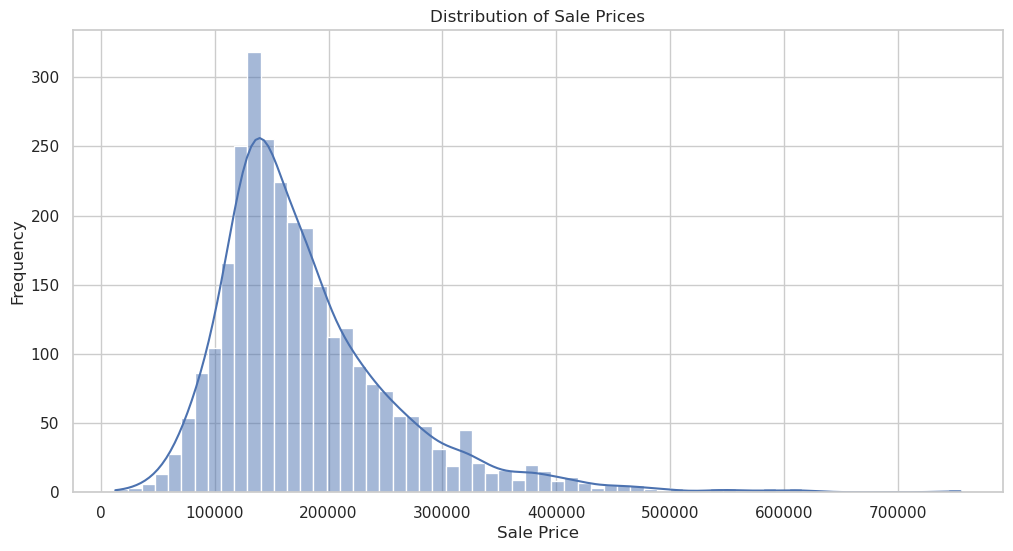

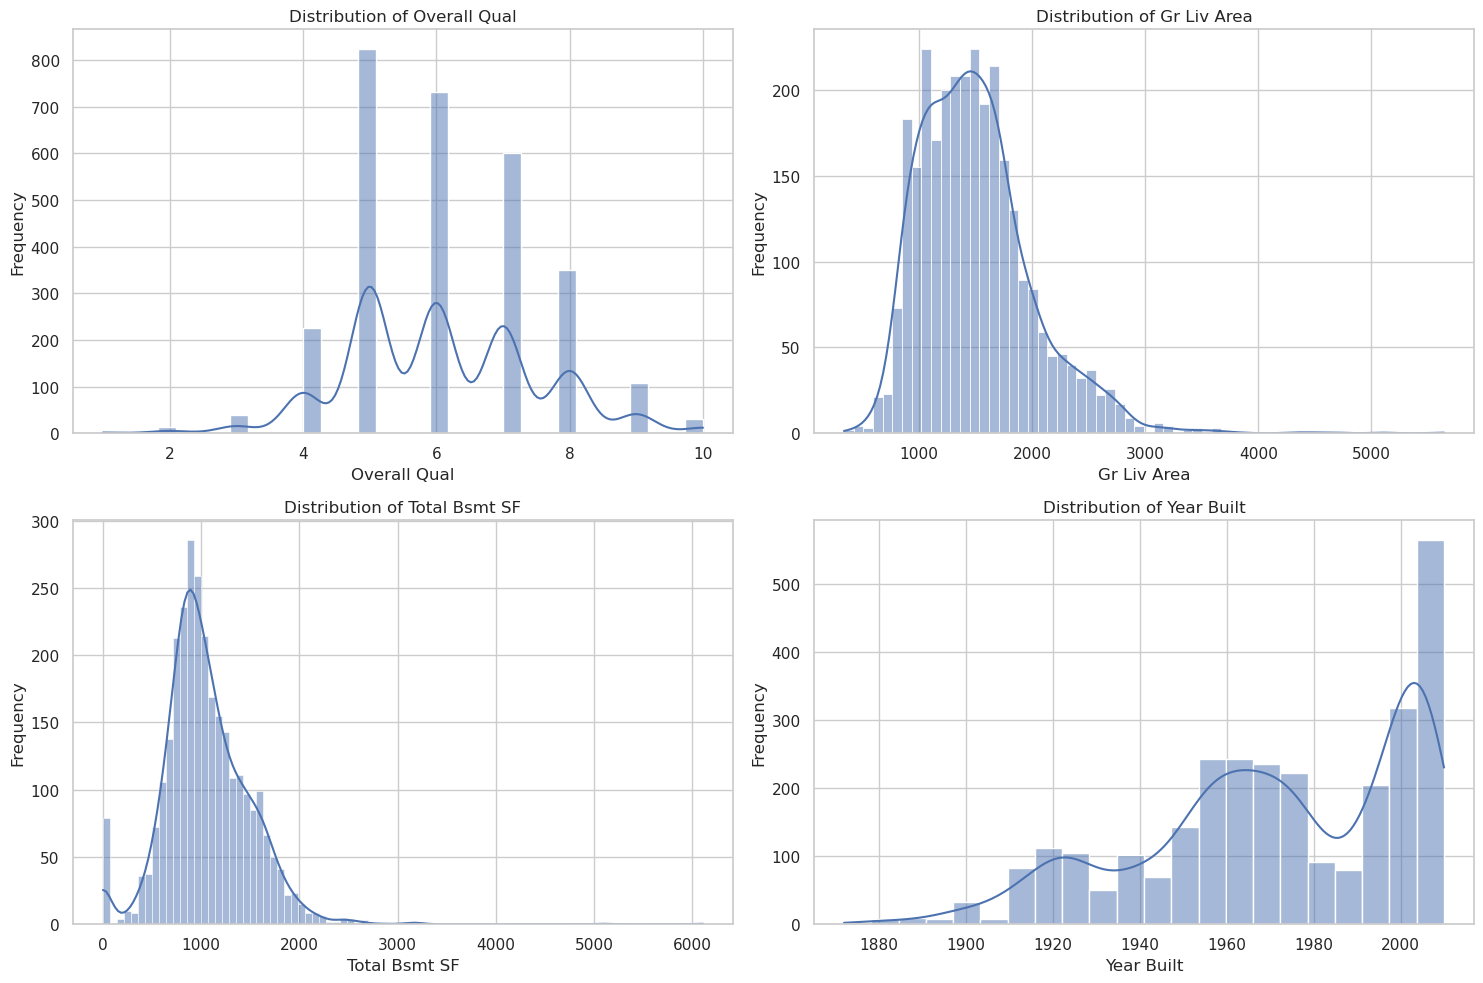

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the plotting style
sns.set(style="whitegrid")

# Plotting the distribution of SalePrice
plt.figure(figsize=(12, 6))
sns.histplot(dataset['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of a few other key features
key_features = ['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', 'Year Built']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, feature in enumerate(key_features):
    sns.histplot(dataset[feature], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {feature}')
    axes[i//2, i%2].set_xlabel(feature)
    axes[i//2, i%2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 1. Sale Price Distribution:
   - The distribution of Sale Prices is right-skewed, indicating that most houses are priced below the mean sale price, and a few houses have much higher prices.
        
   - There is a clear concentration of sales around the \\$100,000 to $200,000 range.

### 2.Key Features Distribution:
   - Overall Quality: This is a categorical feature with a clear mode at a score of 5. Most houses have a quality rating between 5 and 7.
    
   - Above Ground Living Area (Gr Liv Area): The distribution is right-skewed, similar to Sale Price, with most living areas concentrated around 1000 to 2000 square feet.
        
   - Total Basement Area (Total Bsmt SF): This feature also shows a right-skewed distribution. A notable number of houses have no basement (0 square feet).
   
   - Year Built: The distribution shows that more houses were built in recent years. There's a noticeable increase in houses built after the 1950s.

<a id="6-correlation-analysis"></a>
##  6.Correlation Analysis

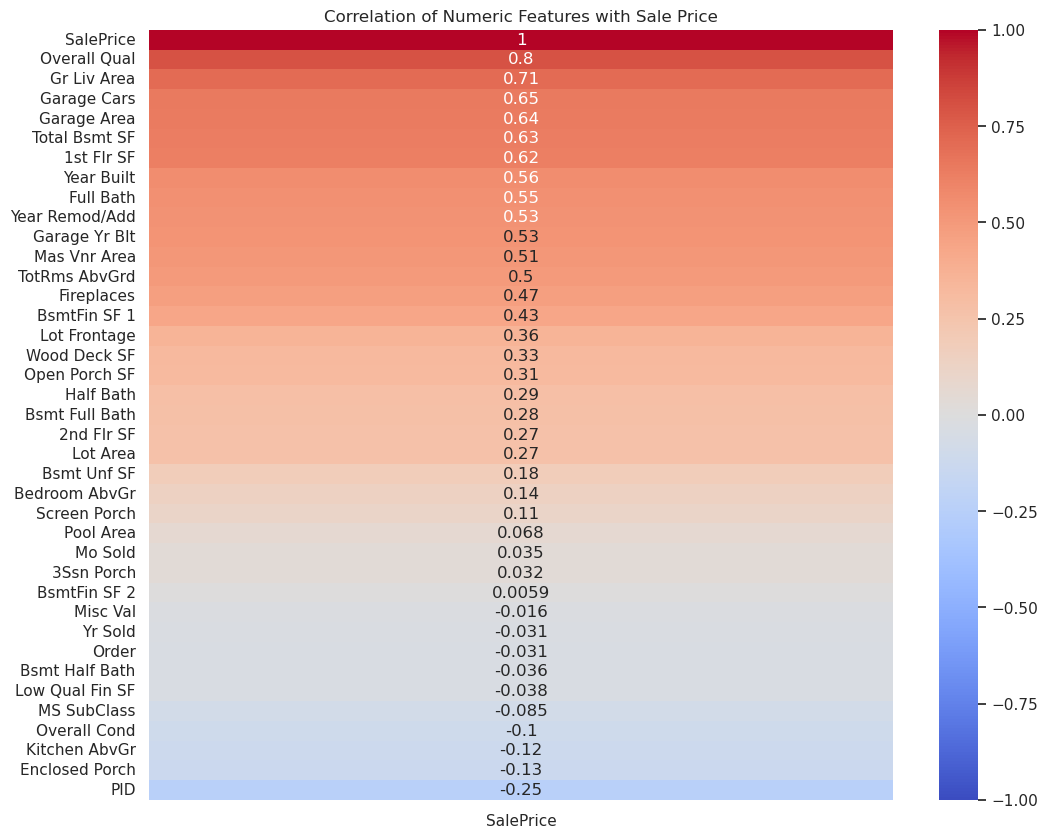

In [19]:
# Selecting only numeric columns for correlation
numeric_dataset = dataset.select_dtypes(include=[np.number])

# Recalculating the correlation matrix
numeric_correlation_matrix = numeric_dataset.corr()

# Plotting the correlation matrix with respect to SalePrice
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_correlation_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Numeric Features with Sale Price')
plt.show()


### 1. Strong Positive Correlations:
   
   - Overall Qual (Overall material and finish quality): This has a strong positive correlation with SalePrice, suggesting that higher quality homes tend to sell for more.
   
   - Gr Liv Area (Above grade (ground) living area): Larger living areas are associated with higher sale prices.
        
   - Garage Cars and Garage Area: Both these garage-related features show a strong positive correlation, indicating that properties with larger and/or more garage space tend to have higher prices.

### 2.Moderate Positive Correlations:
        
   - Total Bsmt SF (Total square feet of basement area) and 1st Flr SF (First Floor square feet) are moderately positively correlated with SalePrice.
        
  - Year Built and Year Remod/Add (Year of remodeling/addition) also show a moderate positive correlation, suggesting newer or more recently updated homes fetch higher prices.

### 3. Negative or Low Correlations:
        
  - Some features have very low or negative correlations, indicating a weak relationship with sale price. For example, PID (Parcel identification number) and Order show negligible correlation.

<a id="data-cleaning"></a>
# DATA CLEANING

<a id="1-dealing-with-missing-value"></a>
## 1. Dealinf with Missing value

In [20]:
# Getting the number of missing values in each column
num_missing = dataset.isna().sum()
# Excluding columns that contains 0 missing values
num_missing = num_missing[num_missing > 0]
# Getting the percentages of missing values
percent_missing = num_missing * 100 / dataset.shape[0]
# Concatenating the number and perecentage of missing values 
# into one dataframe and sorting it
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage
Pool QC,2917,99.56
Misc Feature,2824,96.38
Alley,2732,93.24
Fence,2358,80.48
Mas Vnr Type,1775,60.58
Fireplace Qu,1422,48.53
Lot Frontage,490,16.72
Garage Cond,159,5.43
Garage Qual,159,5.43
Garage Finish,159,5.43


### "Pool QC"

The percentage of missing values in Pool QC column is 99.56% which is very high. We think that a missing value in this column denotes that the corresponding house doesn't have a pool. To verify this, let's take a look at the values of Pool Area column:

In [21]:
dataset["Pool Area"].value_counts()

Pool Area
0      2917
144       1
480       1
576       1
555       1
368       1
444       1
228       1
561       1
519       1
648       1
800       1
512       1
738       1
Name: count, dtype: int64

We can see that there are 2917 entries in Pool Area column that have a value of 0. This verfies our hypothesis that each house without a pool has a missing value in Pool QC column and a value of 0 in Pool Area column. So let's fill the missing values in Pool QC column with "No Pool":

In [22]:
dataset["Pool QC"].fillna("No Pool", inplace=True)

### "Misc Feature"



In [23]:
dataset["Misc Val"].value_counts()

Misc Val
0        2827
400        18
500        13
450         9
600         8
700         7
2000        7
1500        3
1200        3
650         3
480         2
3000        2
2500        2
4500        2
455         1
1512        1
17000       1
1000        1
15500       1
460         1
8300        1
1300        1
560         1
620         1
900         1
1150        1
6500        1
1400        1
750         1
800         1
12500       1
350         1
490         1
80          1
54          1
3500        1
300         1
420         1
Name: count, dtype: int64

Misc Feature has 2824 missing values. Then, as with Pool QC, we can say that each house without a "miscellaneous feature" has a missing value in Misc Feature column and a value of 0 in Misc Val column. So let's fill the missing values in Misc Feature column with "No Feature":

In [24]:
dataset['Misc Feature'].fillna('No feature', inplace=True)

### "Alley",  "Fence", and "Fireplace Qu"
According to the dataset documentation, `NA` in `Alley`, `Fence`, and `Fireplace Qu` columns denotes that the house doesn't have an alley, fence, or fireplace. So we fill in the missing values in these columns with `"No Alley"`, `"No Fence"`, and `"No Fireplace"` accordingly:

In [25]:
dataset['Alley'].fillna('No Alley', inplace=True)
dataset['Fence'].fillna('No Fence', inplace=True)
dataset['Fireplace Qu'].fillna('No Fireplace', inplace=True)

### "Lot Frontage"

As we saw previously, Lot Frontage represents the linear feet of street connected to the house. So we assume that the missing values in this column indicates that the house is not connected to any street, and we fill in the missing values with 0:


In [26]:
dataset['Lot Frontage'].fillna(0, inplace=True)

### "Garage Cond", "Garage Qual", "Garage Finish", "Garage Yr Blt", "Garage Type", "Garage Cars", and "Garage Area"

According to the dataset documentation, NA in Garage Cond, Garage Qual, Garage Finish, and Garage Type indicates that there is no garage in the house. So we fill in the missing values in these columns with "No Garage". We notice that Garage Cond, Garage Qual, Garage Finish, Garage Yr Blt columns have 159 missing values, but Garage Type has 157 and both Garage Cars and Garage Area have one missing value. Let's take a look at the row that contains the missing value in Garage Cars:


In [27]:
garage_columns = [col for col in dataset.columns if col.startswith("Garage")]
dataset[dataset['Garage Cars'].isna()][garage_columns]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
2236,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


We can see that this is the same row that contains the missing value in `Garage Area`, and that all garage columns except `Garage Type` are null in this row, so we will fill the missing values in `Garage Cars` and `Garage Area` with 0.

We saw that there are 2 rows where `Garage Type` is not null while `Garage Cond`, `Garage Qual`, `Garage Finish`, and `Garage Yr Blt` columns are null. Let's take a look at these two rows:

In [28]:
dataset[~pd.isna(dataset['Garage Type']) & 
        pd.isna(dataset['Garage Qual'])][garage_columns]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
1356,Detchd,NaN,NaN,1.00,360.00,NaN,NaN
2236,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


We will replace the values of `Garage Type` with `"No Garage"` in these two rows also.

For `Garage Yr Blt`, we will fill in missing values with 0 since this is a numerical column:

In [30]:
dataset['Garage Cars'].fillna(0, inplace=True)
dataset['Garage Area'].fillna(0, inplace=True)

dataset.loc[~pd.isna(dataset['Garage Type']) & 
            pd.isna(dataset['Garage Qual']), "Garage Type"] = "No Garage"

for col in ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']:
    dataset[col].fillna('No Garage', inplace=True)
    
dataset['Garage Yr Blt'].fillna(0, inplace=True)

### "Bsmt Exposure", "BsmtFin Type 2", "BsmtFin Type 1", "Bsmt Qual", "Bsmt Cond", "Bsmt Half Bath", "Bsmt Full Bath", "Total Bsmt SF", "Bsmt Unf SF", "BsmtFin SF 2", and "BsmtFin SF 1"


In the dataset, `NA` in the first five basement columns means there's no basement, so we replace these missing values with "No Basement." Notably, while these columns typically have 80 missing values, `BsmtFin Type 2` and `Bsmt Exposure` show 81 and 83 missing values, respectively. In contrast, `Bsmt Half Bath` and `Bsmt Full Bath` have only 2 missing values each. Let's inspect the rows with missing `Bsmt Half Bath` values for further clarity.

In [31]:
bsmt_columns = [col for col in dataset.columns if "Bsmt" in col]
dataset[dataset['Bsmt Half Bath'].isna()][bsmt_columns]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
1341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1497,NaN,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,NaN,NaN


The missing values in `Bsmt Half Bath` coincide with those in `Bsmt Full Bath`. Additionally, one of these rows also has missing values in `Total Bsmt SF`, `Bsmt Unf SF`, `BsmtFin SF 2`, and `BsmtFin SF 1`. These rows lack data in `Bsmt Exposure`, `BsmtFin Type 2`, `BsmtFin Type 1`, `Bsmt Qual`, and `Bsmt Cond`, suggesting we fill these missing basement values with 0. Separately, there are 3 rows where `Bsmt Exposure` is null but `BsmtFin Type 1`, `Bsmt Qual`, and `Bsmt Cond` are not, meriting a closer look.

In [32]:
dataset[~pd.isna(dataset['Bsmt Cond']) & 
        pd.isna(dataset['Bsmt Exposure'])][bsmt_columns]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
66,Gd,TA,NaN,Unf,0.00,Unf,0.00,1595.00,1595.00,0.00,0.00
1796,Gd,TA,NaN,Unf,0.00,Unf,0.00,725.00,725.00,0.00,0.00
2779,Gd,TA,NaN,Unf,0.00,Unf,0.00,936.00,936.00,0.00,0.00


We will fill in the missing values in `Bsmt Exposure` for these three rows with `"No"`. According to the dataset documentation, `"No"` for `Bsmt Exposure` means "No Exposure":

Let's now take a look at the row where `BsmtFin Type 2` is null while `BsmtFin Type 1`, `Bsmt Qual`, and `Bsmt Cond` are not null:

In [33]:
dataset[~pd.isna(dataset['Bsmt Cond']) & 
        pd.isna(dataset['BsmtFin Type 2'])][bsmt_columns]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
444,Gd,TA,No,GLQ,1124.00,NaN,479.00,1603.00,3206.00,1.00,0.00


We will fill in the missing value in `BsmtFin Type 2` for this row with `"Unf"`. According to the dataset documentation, `"Unf"` for `BsmtFin Type 2` means "Unfinished":

In [34]:
for col in ["Bsmt Half Bath", "Bsmt Full Bath", "Total Bsmt SF", 
            "Bsmt Unf SF", "BsmtFin SF 2", "BsmtFin SF 1"]:
    dataset[col].fillna(0, inplace=True)

dataset.loc[~pd.isna(dataset['Bsmt Cond']) & 
            pd.isna(dataset['Bsmt Exposure']), "Bsmt Exposure"] = "No"
dataset.loc[~pd.isna(dataset['Bsmt Cond']) & 
            pd.isna(dataset['BsmtFin Type 2']), "BsmtFin Type 2"] = "Unf"

for col in ["Bsmt Exposure", "BsmtFin Type 2", 
            "BsmtFin Type 1", "Bsmt Qual", "Bsmt Cond"]:
    dataset[col].fillna("No Basement", inplace=True)

### Mas Vnr Area and Mas Vnr Type

Each of these two columns have 23 missing values. We will fill in these missing values with "None" for Mas Vnr Type and with 0 for Mas Vnr Area. We use "None" for Mas Vnr Type because in the dataset documentation, "None" for Mas Vnr Type means "None" (i.e. no masonry veneer):


In [35]:
dataset['Mas Vnr Area'].fillna(0, inplace=True)
dataset['Mas Vnr Type'].fillna("None", inplace=True)

### Electrical

This column has one missing value. We will fill in this value with the mode of this column:

In [36]:
dataset['Electrical'].fillna(dataset['Electrical'].mode()[0], inplace=True)

#### Now let's check if there is any remaining missing value in our dataset:

In [37]:
dataset.isna().values.sum()

0

<a id="2-outlier-removal"></a>
## 2. Outlier Removal


### plotting `SalePrice` against `Gr Liv Area` to spot the outliers.

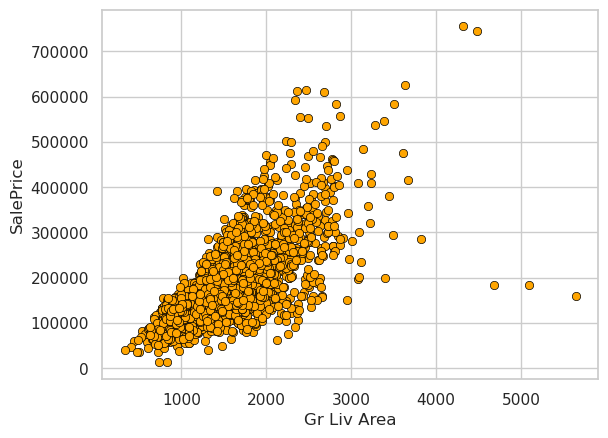

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.scatter(x=dataset['Gr Liv Area'], y=dataset['SalePrice'], 
            color="orange", edgecolors="#000000", linewidths=0.5);
plt.xlabel("Gr Liv Area"); plt.ylabel("SalePrice");

### We can see five outlier values in the plot above.

In [39]:
outlirt_columns = ["Gr Liv Area"] + \
                  [col for col in dataset.columns if "Sale" in col]
dataset[dataset["Gr Liv Area"] > 4000][outlirt_columns]

,Gr Liv Area,Sale Type,Sale Condition,SalePrice
1498,5642,New,Partial,160000
1760,4476,WD,Abnorml,745000
1767,4316,WD,Normal,755000
2180,5095,New,Partial,183850
2181,4676,New,Partial,184750


In [40]:
# REMOVING Outliers
dataset = dataset[dataset["Gr Liv Area"] < 4000]

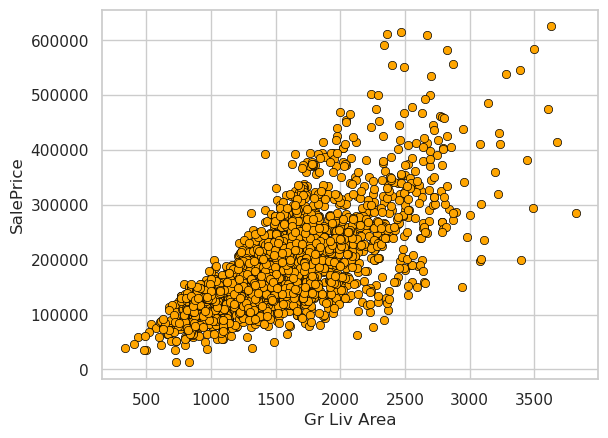

In [41]:
plt.scatter(x=dataset['Gr Liv Area'], y=dataset['SalePrice'], 
            color="orange", edgecolors="#000000", linewidths=0.5);
plt.xlabel("Gr Liv Area"); plt.ylabel("SalePrice");

To avoid problems in modeling later, we will reset our dataset index after removing the outlier rows, so no gaps remain in our dataset index:

In [42]:
dataset.reset_index(drop=True, inplace=True)

<a id="3-dropping-unimportant-columns"></a>
## 3. Dropping Unimportant Columns


The columns to be deleted are `Order` and `PID`:

In [43]:
dataset.drop(['Order', 'PID'], axis=1, inplace=True)

/tmp/ipykernel_10134/4030495044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(['Order', 'PID'], axis=1, inplace=True)


<a id="feature-engineering"></a>
# FEATURE ENGINEERING

<a id="1-derived-feature-creation"></a>
## 1. Derived Feature Creation

Recognizing the strong positive correlation between SalePrice, Overall Qual, and Gr Liv Area, we'll enhance our predictive model by generating polynomial features. Specifically, we will create new features by squaring and cubing the values of Overall Qual and Gr Liv Area. Additionally, we'll introduce a feature representing the product of these two key features.

In [55]:
# Create polynomial features based on 'Overall Qual' and 'Gr Liv Area'
for f in ["Overall Qual", "Gr Liv Area"]:
    dataset[f + "_p2"] = dataset[f] ** 2
    dataset[f + "_p3"] = dataset[f] ** 3
# Create interaction feature    
dataset["OverallQual_GrLivArea"] = \
    dataset["Overall Qual"] * dataset["Gr Liv Area"]

To address multicollinearity, we'll eliminate one feature from each pair of highly correlated predictors. We identified two such pairs: Garage Cars and Garage Area, and Gr Liv Area and TotRms AbvGrd. To mitigate this issue, we will remove Garage Cars from the first pair and TotRms AbvGrd from the second.

Multicollinearity occurs when predictors in a regression model are highly correlated, leading to difficulties in isolating individual variable effects and potentially causing unstable estimates. It's often addressed by removing or combining correlated variables.

In [56]:
# Address multicollinearity by dropping one feature from each pair of highly correlated predictors
dataset.drop(["Garage Cars", "TotRms AbvGrd"], axis=1, inplace=True)

<a id="2-ordinal-variables-mapping"></a>
## 2. Ordinal Variables Mapping

For ordinal variables like Bsmt Cond in our dataset, we'll convert their categorical rankings to numerical values for machine learning compatibility. For instance, Bsmt Cond values - "No Basement" to 0, "Po" (Poor) to 1, "Fa" (Fair) to 2, "TA" (Typical) to 3, "Gd" (Good) to 4, and "Ex" (Excellent) to 5 - will be mapped numerically.

This approach will be applied to all ordinal features including Exter Qual, Bsmt Qual, and others, assigning numbers to their categorical values based on the dataset documentation.

In [57]:
print("Unique values in 'Bsmt Cond' column:")
print(dataset['Bsmt Cond'].unique().tolist())

Unique values in 'Bsmt Cond' column:
['Gd', 'TA', 'No Basement', 'Po', 'Fa', 'Ex']


In [58]:
mp = {'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0}
dataset['Exter Qual'] = dataset['Exter Qual'].map(mp)
dataset['Exter Cond'] = dataset['Exter Cond'].map(mp)
dataset['Heating QC'] = dataset['Heating QC'].map(mp)
dataset['Kitchen Qual'] = dataset['Kitchen Qual'].map(mp)

mp = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Basement':0}
dataset['Bsmt Qual'] = dataset['Bsmt Qual'].map(mp)
dataset['Bsmt Cond'] = dataset['Bsmt Cond'].map(mp)
dataset['Bsmt Exposure'] = dataset['Bsmt Exposure'].map(
    {'Gd':4,'Av':3,'Mn':2,'No':1,'No Basement':0})

mp = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'No Basement':0}
dataset['BsmtFin Type 1'] = dataset['BsmtFin Type 1'].map(mp)
dataset['BsmtFin Type 2'] = dataset['BsmtFin Type 2'].map(mp)

dataset['Central Air'] = dataset['Central Air'].map({'Y':1,'N':0})
dataset['Functional'] = dataset['Functional'].map(
    {'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,
     'Maj2':2,'Sev':1,'Sal':0})
dataset['Fireplace Qu'] = dataset['Fireplace Qu'].map(
    {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Fireplace':0})
dataset['Garage Finish'] = dataset['Garage Finish'].map(
    {'Fin':3,'RFn':2,'Unf':1,'No Garage':0})
dataset['Garage Qual'] = dataset['Garage Qual'].map(
    {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Garage':0})
dataset['Garage Cond'] = dataset['Garage Cond'].map(
    {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Garage':0})
dataset['Pool QC'] = dataset['Pool QC'].map(
    {'Ex':4,'Gd':3,'TA':2,'Fa':1,'No Pool':0})
dataset['Land Slope'] = dataset['Land Slope'].map(
    {'Sev': 2, 'Mod': 1, 'Gtl': 0})
dataset['Fence'] = dataset['Fence'].map(
    {'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'No Fence':0})

<a id="3-one-hot-encoding-categorical-features"></a>
## 3. One-Hot Encoding ( Categorical Features)


We'll use one-hot encoding to transform categorical features into binary variables, with each unique category becoming a binary variable (0 or 1). We'll utilize Pandas' `get_dummies()` function for this purpose.

As an illustration, consider the `Paved Drive` variable, which indicates driveway pavement type with values `Y` (Paved), `P` (Partial Pavement), and `N` (Dirt/Gravel). Let's examine the `Paved Drive` values in the first few rows of our dataset after applying one-hot encoding.

In [59]:
dataset[['Paved Drive']].head()

,Paved Drive
0,P
1,Y
2,Y
3,Y
4,Y


In [60]:
dataset = pd.get_dummies(dataset)

In [61]:
pavedDrive_oneHot = [c for c in dataset.columns if c.startswith("Paved")]
dataset[pavedDrive_oneHot].head()

,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,False,True,False
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True


Paved Drive column is converted to 1 in Paved Drive_P and zeros in Paved Drive_N and Paved Drive_Y after one-hot encoding.

<a id="modeling"></a>
# MODELING

<a id="setup"></a>
## Setup

In [78]:
import os
import boto3
import re
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import sagemaker.amazon.common as smac

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
s3 = boto3.client("s3")


# S3 bucket for saving code and model artifacts.
bucket = "final-project-ryhan"

prefix = (
    "sagemaker/Ames-housing-price-prediction"  # place to upload training files within the bucket
)
print (region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
us-east-1


<a id="prediction-type"></a>
# Prediction Type

In this project, our goal is to predict a house's price based on its attributes. The target price is a continuous variable, meaning it can take any real number value. This is evident from the `SalePrice` variable in our dataset, which represents the price we aim to predict.

In [62]:
dataset[['SalePrice']].head()

,SalePrice
0,215000
1,105000
2,172000
3,244000
4,189900


#### That means that the prediction type that is appropriate to our problem is **regression**.


<a id="feature-scaling-with-standanrdscaler"></a>
## Feature Scaling with standanrdscaler

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# We need to fit the scaler to our data before transformation
dataset.loc[:, dataset.columns != 'SalePrice'] = scaler.fit_transform(
    dataset.loc[:, dataset.columns != 'SalePrice'])

<a id="splitting-data-train-test-split"></a>
## SPLITTING DATA (TRAIN-Validation-TEST-SPLIT)

In [84]:
from sklearn.model_selection import train_test_split

# First, split the dataset into a larger training set and a temporary set (combining validation and test)
train_df, temp_df = train_test_split(dataset, test_size=0.3, random_state=42)

# Now, split the temporary set into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Separating the features and the target variable for each set
X_train = train_df.drop(columns=['SalePrice'])
Y_train = train_df['SalePrice']

X_val = val_df.drop(columns=['SalePrice'])
Y_val = val_df['SalePrice']

X_test = test_df.drop(columns=['SalePrice'])
Y_test = test_df['SalePrice']


<a id="saving-train-data-to-s3"></a>
## Saving Train data to s3

### I'll convert the dataset to the recordIO-wrapped protobuf format  before saving to s3


In [88]:
import sagemaker.amazon.common as smac

# Convert pandas DataFrames to numpy arrays
X_train_np = X_train.values.astype("float32")
Y_train_np = Y_train.values.astype("float32")
X_val_np = X_val.values.astype("float32")
Y_val_np = Y_val.values.astype("float32")

# Now, convert the datasets to the recordIO-wrapped protobuf format
train_file = "Project_XGB_train_data.csv"
val_file = "Project_XGB_val_data.csv"

# Saving training data
f_train = io.BytesIO()  # Create an in-memory bytes buffer object that can be used as a file object
smac.write_numpy_to_dense_tensor(f_train, X_train_np, Y_train_np)
f_train.seek(0)  # Reset the file's position to the beginning

# Saving validation data
f_val = io.BytesIO()
smac.write_numpy_to_dense_tensor(f_val, X_val_np, Y_val_np)
f_val.seek(0)

# Upload the files to Amazon S3
s3_resource = boto3.Session().resource("s3")

s3_resource.Bucket(bucket).Object(os.path.join(prefix, "train", train_file)).upload_fileobj(f_train)
s3_resource.Bucket(bucket).Object(os.path.join(prefix, "validation", val_file)).upload_fileobj(f_val)


<a id="xgboost-model"></a>
## XGBOOST MODEL

<a id="xgboost-container-image-and-training-job"></a>
### XGBoost container image and training job

In [81]:
from sagemaker.image_uris import retrieve

container = retrieve(framework="xgboost", region=region, version="1.7-1")

In [91]:
XGB_job = "FinalProject-Ryhan-XGBoost-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", XGB_job)

xgb_training_params = {
    "TrainingJobName": XGB_job,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.c4.2xlarge", "VolumeSizeInGB": 10},
    "HyperParameters": {
        "max_depth": "5",           # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
        "eta": "0.2",               # Step size shrinkage used in updates to prevent overfitting. After each boosting step, we can directly get the weights of new features.
        "gamma": "4",               # Minimum loss reduction required to make a further partition on a leaf node of the tree.
        "min_child_weight": "6",    # Minimum sum of instance weight (hessian) needed in a child.
        "verbosity": "0",           # Verbosity of printing messages. Valid values are 0 (silent), 1 (warning), 2 (info), and 3 (debug).
        "objective": "reg:squarederror",  # Objective function for regression.
        # Removed num_class as it's not relevant for regression
        "num_round": "10"           # The number of rounds for boosting
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "OutputDataConfig": {
        "S3OutputPath": f"s3://{bucket}/{prefix}/xgboost"
    },
    "InputDataConfig": [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": f"s3://{bucket}/{prefix}/train/",
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "application/x-recordio-protobuf",
        "CompressionType": "None",
        "RecordWrapperType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": f"s3://{bucket}/{prefix}/validation/",
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "application/x-recordio-protobuf",
        "CompressionType": "None",
        "RecordWrapperType": "None"
    }
]
}

Job name is: FinalProject-Ryhan-XGBoost-2023-11-26-19-18-34


<a id="training"></a>
## TRAINING

In [92]:
%%time

sm = boto3.client("sagemaker")

sm.create_training_job(**xgb_training_params)

# Checking training job status
status = sm.describe_training_job(TrainingJobName=XGB_job)["TrainingJobStatus"]
print(status)

sm.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=XGB_job)
if status == "Failed":
    message = sm.describe_training_job(TrainingJobName=XGB_job)["FailureReason"]
    print("Training failed with the following error: {}".format(message))
    raise Exception("Training job failed")

InProgress
CPU times: user 91.1 ms, sys: 5.51 ms, total: 96.6 ms
Wall time: 4min


<a id="hyperparameter-tuning"></a>
# HYPERPARAMETER TUNING

In [93]:
from time import gmtime, strftime, sleep

tuning_job_name = "FinalProj-Ryhan-XGB-" + strftime("%d-%H-%M-%S", gmtime())

print(tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
        "ContinuousParameterRanges": [
            {"MaxValue": "0.5", "MinValue": "0.01", "Name": "eta"},
            {"MaxValue": "10", "MinValue": "1", "Name": "gamma"},
            {"MaxValue": "1", "MinValue": "0.5", "Name": "subsample"},
            {"MaxValue": "1", "MinValue": "0.5", "Name": "colsample_bytree"}
        ],
        "IntegerParameterRanges": [
            {"MaxValue": "10", "MinValue": "3", "Name": "max_depth"},
            {"MaxValue": "10", "MinValue": "1", "Name": "min_child_weight"}
        ]
    },
    "ResourceLimits": {"MaxNumberOfTrainingJobs": 20, "MaxParallelTrainingJobs": 3},
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:rmse", "Type": "Minimize"}
}

FinalProj-Ryhan-XGB-26-19-33-53


## I'm using Root Mean Square Error on the validation dataset as the objective metric

A lower RMSE value indicates better model performance.

In [94]:
training_image = retrieve(framework="xgboost", region=region, version="1.5-1")

s3_input_train = f"s3://{bucket}/{prefix}/train"
s3_input_validation = f"s3://{bucket}/{prefix}/validation"

training_job_definition = {
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "CompressionType": "None",
            "ContentType": "application/x-recordio-protobuf",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,
                }
            },
        },
        {
            "ChannelName": "validation",
            "CompressionType": "None",
            "ContentType": "application/x-recordio-protobuf",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,
                }
            },
        },
    ],
    "OutputDataConfig": {"S3OutputPath": f"s3://{bucket}/{prefix}/output"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},
    "RoleArn": role,
    "StaticHyperParameters": {
        "eval_metric": "rmse",
        "num_round": "100",
        "objective": "reg:squarederror",
        "rate_drop": "0.3",
        "tweedie_variance_power": "1.4",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},
}

sm = boto3.client("sagemaker")
sm.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    HyperParameterTuningJobConfig=tuning_job_config,
    TrainingJobDefinition=training_job_definition,
)


{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:378639026377:hyper-parameter-tuning-job/FinalProj-Ryhan-XGB-26-19-33-53',
 'ResponseMetadata': {'RequestId': '9167091f-3957-4bae-b007-4c2ea832d24a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9167091f-3957-4bae-b007-4c2ea832d24a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '132',
   'date': 'Sun, 26 Nov 2023 19:37:09 GMT'},
  'RetryAttempts': 0}}

In [95]:
sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)["HyperParameterTuningJobStatus"]

'InProgress'

In [96]:
sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobName']

'FinalProj-Ryhan-XGB-26-19-33-53'

In [97]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sm.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

20 training jobs have completed


In [98]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2023, 11, 26, 19, 41, 11, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:rmse',
                                                 'Value': 20404.921875},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 11, 26, 19, 41, 58, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:378639026377:training-job/FinalProj-Ryhan-XGB-26-19-33-53-005-5a2863a9',
 'TrainingJobName': 'FinalProj-Ryhan-XGB-26-19-33-53-005-5a2863a9',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 11, 26, 19, 41, 16, tzinfo=tzlocal()),
 'TunedHyperParameters': {'colsample_bytree': '0.5781199849818944',
                          'eta': '0.09900286889914324',
                          'gamma': '8.163769086435273',
                          'max_depth': '5',
                          'min_child_weight': '1',
                          'subsample': '

### From the output we see:
- Metric: The best model achieved a Root Mean Square Error (RMSE) of 20404.921875 on the validation set.

- Hyperparameters: Optimal settings include a learning rate (eta) of 0.0990, max_depth of 5, min_child_weight of 1, and specific settings for colsample_bytree, gamma, and subsample.

<a id="inferencing"></a>
# INFERENCING

<a id="hosting-the-model"></a>
## HOSTING THE MODEL

In [99]:
best_training_job_name = tuning_job_result["BestTrainingJob"]["TrainingJobName"]
# Retrieve the best model's S3 model artifacts
best_model_artifacts = sm.describe_training_job(TrainingJobName=best_training_job_name)["ModelArtifacts"]["S3ModelArtifacts"]

XGB_hosting_container = {
    "Image": container,
    "ModelDataUrl": best_model_artifacts
}

# Create the SageMaker model for hosting
create_model_response = sm.create_model(
    ModelName=best_training_job_name,  # Use the best training job name as the model name
    ExecutionRoleArn=role,
    PrimaryContainer=XGB_hosting_container,
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-east-1:378639026377:model/finalproj-ryhan-xgb-26-19-33-53-005-5a2863a9


<a id="endpoint-config"></a>
## Endpoint Config

In [102]:
model_name = best_training_job_name

XGB_endpoint_config = "FinalProject-Ryhan-XGB-endpoint-config-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(XGB_endpoint_config)

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=XGB_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

FinalProject-Ryhan-XGB-endpoint-config-2023-11-26-19-59-37
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:378639026377:endpoint-config/finalproject-ryhan-xgb-endpoint-config-2023-11-26-19-59-37


<a id="creating-endpoint"></a>
## Creating Endpoint

In [103]:
%%time

# Create a unique name for the SageMaker endpoint
XGB_endpoint = "FinalProject-Ryhan-XGB-endpoint-" + time.strftime("%Y%m%d%H%M", time.gmtime())
print(XGB_endpoint)

create_endpoint_response = sm.create_endpoint(
    EndpointName=XGB_endpoint, 
    EndpointConfigName=XGB_endpoint_config  
)
print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

# Wait for the endpoint to be in service
sm.get_waiter("endpoint_in_service").wait(EndpointName=XGB_endpoint)

# Check the status of the endpoint
resp = sm.describe_endpoint(EndpointName=XGB_endpoint)
status = resp["EndpointStatus"]
print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

# Raise an exception if the endpoint is not in service
if status != "InService":
    raise Exception("Endpoint creation did not succeed")

FinalProject-Ryhan-XGB-endpoint-202311262001
Endpoint Arn: arn:aws:sagemaker:us-east-1:378639026377:endpoint/finalproject-ryhan-xgb-endpoint-202311262001
Arn: arn:aws:sagemaker:us-east-1:378639026377:endpoint/finalproject-ryhan-xgb-endpoint-202311262001
Status: InService
CPU times: user 80.5 ms, sys: 0 ns, total: 80.5 ms
Wall time: 4min 1s


<a id="prediction"></a>
## PREDICTION

### Function to convert an array to a csv

In [105]:
def np2csv(arr):
    csv = io.BytesIO() #the function gets an array (Numpy array) and creates an in-memory binary buffer named csv
    np.savetxt(csv, arr, delimiter=",", fmt="%g") # write the array 'arr' to csv object, columns should be seperated by commas. The fmt="%g" removes unneccesary decimals when saving and use scientific notation.
    # In the following line:
    # csv.getvalue() retrieves the entire contents of the buffer csv as a byte string.
    # .decode() converts the byte string into a normal Python string by decoding it using the default UTF-8 encoding.
    #.rstrip() removes any trailing whitespace or newlines from the end of the string.
    return csv.getvalue().decode().rstrip()

In [106]:
import numpy as np
import pandas as pd
import boto3
from io import StringIO

runtime = boto3.client("runtime.sagemaker")

# Assuming np2csv converts a numpy array to a CSV string
payload = np2csv(X_test)  

# Save X_test as a CSV for inspection
X_test_df = pd.DataFrame(X_test)
X_test_df.to_csv('X_test.csv', index=False)

In [107]:
%%time
# Invoke the SageMaker endpoint
try:
    response = runtime.invoke_endpoint(
        EndpointName=XGB_endpoint, 
        ContentType="text/csv", 
        Body=payload
    )

    response_body = response["Body"].read().decode()
    print("Raw response body:", response_body)  # Print raw response for inspection

    # Convert the response body to an array of predictions
    test_pred = np.fromstring(response_body, sep='\n')

except Exception as e:
    print("Error during prediction:", e)

Raw response body: 140587.515625
208920.453125
83030.9609375
233810.203125
201558.265625
377092.46875
196612.671875
263335.21875
227033.359375
225024.28125
137573.171875
137601.15625
400711.21875
132449.53125
192363.28125
137028.09375
147441.765625
153926.78125
217172.9375
151716.234375
347419.03125
163031.53125
193339.109375
168385.3125
178125.625
109803.6640625
203618.546875
183732.203125
184663.34375
172024.828125
280403.59375
208290.921875
236388.25
160715.9375
207789.09375
113738.21875
212152.71875
164967.46875
185999.921875
270228.53125
138819.96875
209794.390625
150787.1875
133749.0
327222.96875
241940.265625
99220.296875
117751.3203125
146774.640625
231655.390625
187462.765625
135017.328125
128284.2265625
122762.546875
140996.84375
83765.578125
152177.109375
130699.4140625
121643.9921875
189581.28125
218373.359375
108981.3984375
263885.84375
210182.765625
297836.09375
158045.140625
285096.65625
181962.390625
83547.5859375
227298.515625
219058.65625
177664.703125
208074.3125
135

In [108]:
test_pred

array([140587.515625  , 208920.453125  ,  83030.9609375 , 233810.203125  ,
       201558.265625  , 377092.46875   , 196612.671875  , 263335.21875   ,
       227033.359375  , 225024.28125   , 137573.171875  , 137601.15625   ,
       400711.21875   , 132449.53125   , 192363.28125   , 137028.09375   ,
       147441.765625  , 153926.78125   , 217172.9375    , 151716.234375  ,
       347419.03125   , 163031.53125   , 193339.109375  , 168385.3125    ,
       178125.625     , 109803.6640625 , 203618.546875  , 183732.203125  ,
       184663.34375   , 172024.828125  , 280403.59375   , 208290.921875  ,
       236388.25      , 160715.9375    , 207789.09375   , 113738.21875   ,
       212152.71875   , 164967.46875   , 185999.921875  , 270228.53125   ,
       138819.96875   , 209794.390625  , 150787.1875    , 133749.        ,
       327222.96875   , 241940.265625  ,  99220.296875  , 117751.3203125 ,
       146774.640625  , 231655.390625  , 187462.765625  , 135017.328125  ,
       128284.2265625 , 1

<a id="mae-comparison"></a>
## MAE Comparison

In [115]:
# MAE Calculation
test_mae_XGB = np.mean(np.abs(Y_test - test_pred))
test_mae_baseline = np.mean(np.abs(Y_test - np.median(Y_train)))

print("Test MAE Baseline:", round(test_mae_baseline, 3))
print("Test MAE XGBoost:", round(test_mae_XGB, 3))

Test MAE Baseline: 56598.845
Test MAE XGBoost: 12491.507


<a id="prediction-accuracy-test-mae-rmse-and-r2"></a>
## Prediction Accuracy Test: MAE, RMSE and r^2

In [116]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming 'test_pred' contains your model predictions and 'Y_test' contains the true values

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, test_pred)
print("Mean Absolute Error (MAE):", round(mae, 3))

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(Y_test, test_pred))
print("Root Mean Square Error (RMSE):", round(rmse, 3))

# Calculate R-squared (R²)
r2 = r2_score(Y_test, test_pred)
print("R-squared (R²):", round(r2, 3))


Mean Absolute Error (MAE): 12491.507
Root Mean Square Error (RMSE): 18191.345
R-squared (R²): 0.943


<a id="report"></a>
# REPORT

## In plain English, the metrics for my model can be explained as follows:

### - Mean Absolute Error (MAE): 12491.507
        On average, the predictions of the house prices are about \\$12,491.51 off from their actual market values. 
        
### - Root Mean Square Error (RMSE): 18191.345
        The RMSE being \\$18,191.35 indicates that the typical error (how much the prediction deviates from the actual price) is usually around this amount. RMSE is higher than MAE, which suggests that there are some predictions with larger errors. This metric penalizes larger errors more heavily than smaller ones.

### - R-squared (R²): 0.943
        The R² value of 0.943, or 94.3\%, shows how well the variables I've used in my model explain the variation in house prices. In this case, it suggests that 94.3% of the variability in house prices can be explained by my model. This is quite high, indicating my model fits the data well. 
        
        An R² of 1 means perfect prediction with no error
        Since my mode's r square value is 0.943 (pretty close to 1) - that means the model explains 94% of the variance in the data

# Cleanup

In [117]:
#Deleting the endpoint
sm.delete_endpoint(EndpointName=XGB_endpoint)

{'ResponseMetadata': {'RequestId': '701cf8b3-990d-44f9-966d-7554a8e26baa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '701cf8b3-990d-44f9-966d-7554a8e26baa',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sun, 26 Nov 2023 21:00:40 GMT'},
  'RetryAttempts': 0}}